##### import libary

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from sklearn.metrics import confusion_matrix
import utility
import importlib
import time
importlib.reload(utility)
pd.set_option('mode.chained_assignment', None)

1. return_combined_fitness_esm_data: The function combines fitness and ESM score data, calculating the median values for each generation, and returns a DataFrame with columns 'generation_number', 'median fitness', and 'median esm_score'.

2. return_generation_grouped_dataframe: The function groups and summarizes data by generation and mutator status, additionally creating a new column based on generation thresholds. It requires an input DataFrame with specific columns ('generation_number' and 'mutator') and returns a DataFrame with grouped data and the additional grouping column.

3. return_mutator_non_mutator_column_name_wise_graph_together: The function plots three subplots for a specified column against generation number, separately for mutator, non-mutator, and the entire population.

##### This analysis use fitness info sheet and generation wise allele count information sheet for each unique mutation from ecoli metasheet.

Generation wise fitness information --> Available in Fitness2_experimental sheet of ecoli metadata
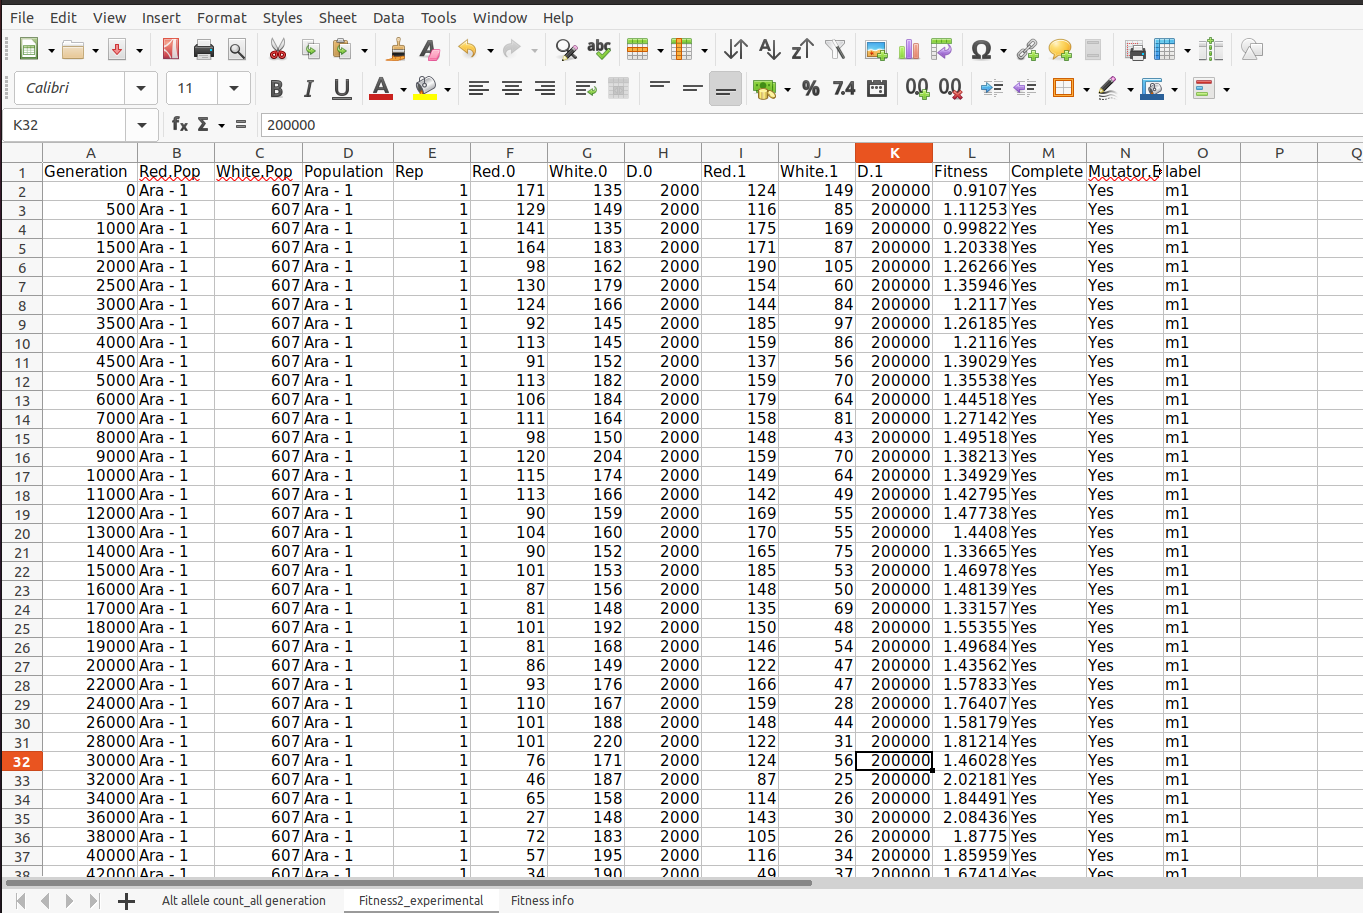

Generation wise allele count information --> Available in Alt allele count_all generation sheet of ecoli metadata
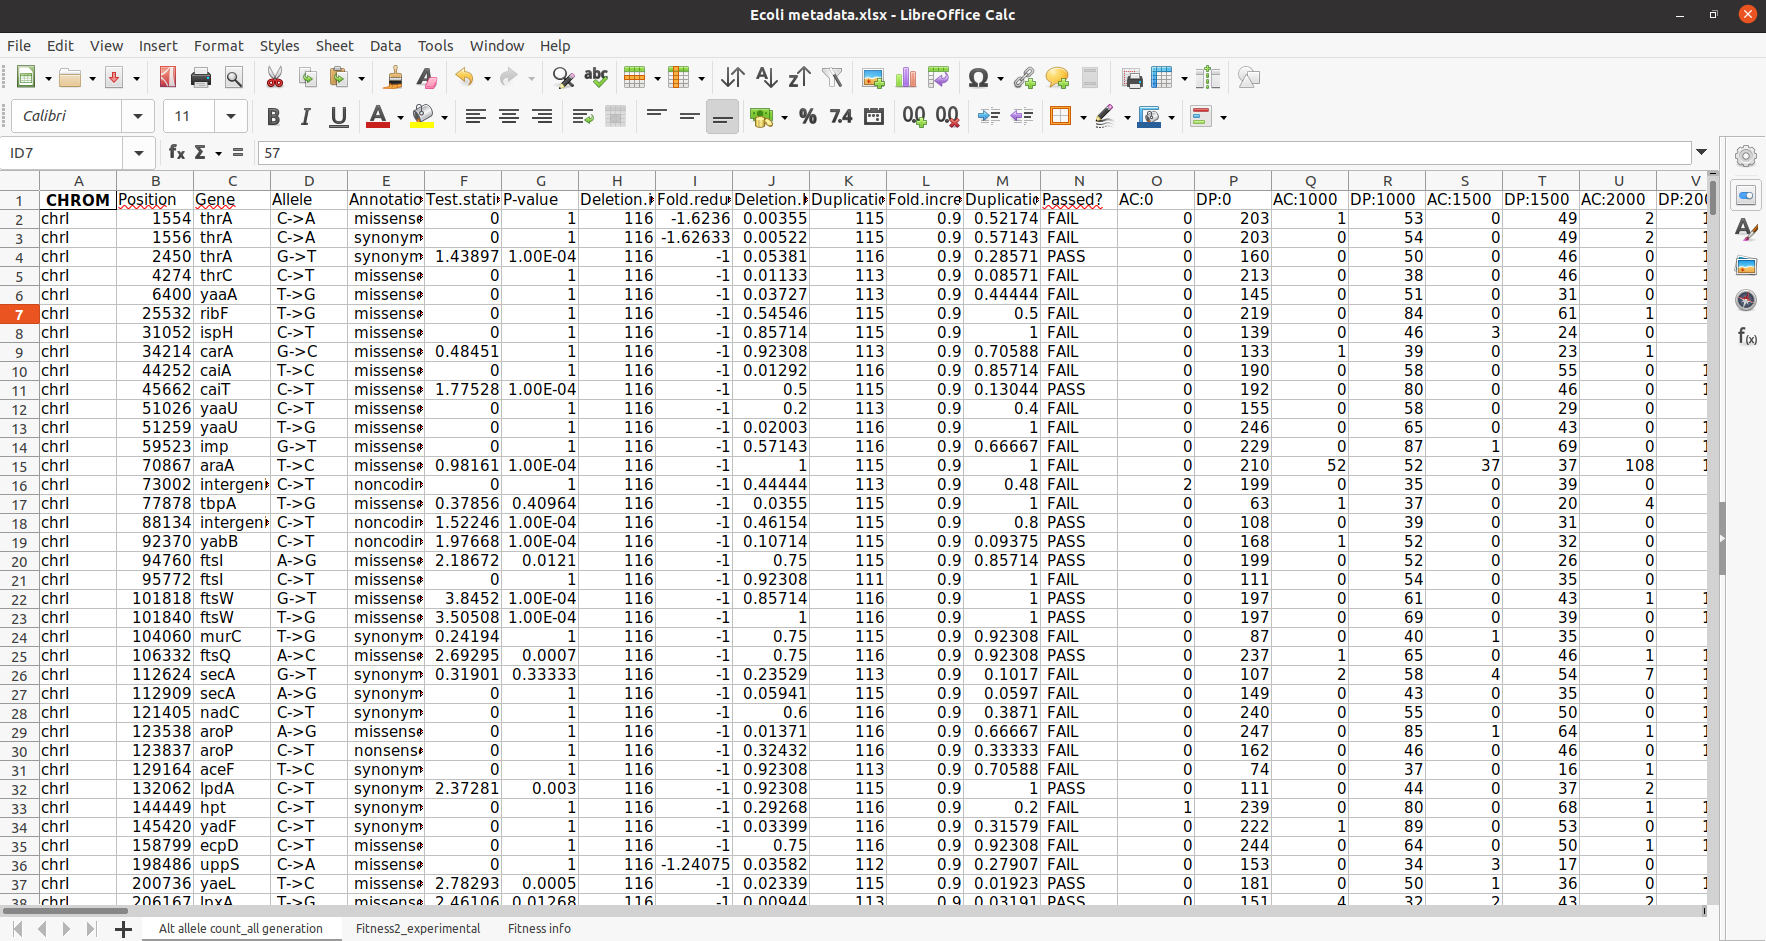

##### Read fitness data from metadata

In [2]:
df_Fitness2_experimental = pd.read_excel("/home/abhishekh/ecoli/data/Ecoli metadata.xlsx", sheet_name="Fitness2_experimental")
df_Fitness2_experimental = df_Fitness2_experimental.rename(columns={'label ': 'label'})
df_Fitness2_experimental.head()

,Generation,Red.Pop,White.Pop,Population,Rep,Red.0,White.0,D.0,Red.1,White.1,D.1,Fitness,Complete,Mutator.Ever,label
0,0,Ara - 1,607,Ara - 1,1,171.0,135.0,2000,124.0,149.0,200000,0.910700,Yes,Yes,m1
1,500,Ara - 1,607,Ara - 1,1,129.0,149.0,2000,116.0,85.0,200000,1.112534,Yes,Yes,m1
2,1000,Ara - 1,607,Ara - 1,1,141.0,135.0,2000,175.0,169.0,200000,0.998220,Yes,Yes,m1
3,1500,Ara - 1,607,Ara - 1,1,164.0,183.0,2000,171.0,87.0,200000,1.203381,Yes,Yes,m1
4,2000,Ara - 1,607,Ara - 1,1,98.0,162.0,2000,190.0,105.0,200000,1.262659,Yes,Yes,m1


##### check if any duplicate row is present in fitness sheet

In [3]:
df_Fitness2_experimental[df_Fitness2_experimental.duplicated()] # No duplicate row found

,Generation,Red.Pop,White.Pop,Population,Rep,Red.0,White.0,D.0,Red.1,White.1,D.1,Fitness,Complete,Mutator.Ever,label


##### Read allele count and generation data from metasheet

In [4]:
df_Alt_allele_count_all_generation = pd.read_excel("/home/abhishekh/ecoli/data/Ecoli metadata.xlsx", sheet_name= "Alt allele count_all generation")
df_Alt_allele_count_all_generation.head()

,CHROM,Position,Gene,Allele,Annotation,Test.statistic,P-value,Deletion.index,Fold.reduction,Deletion.P-value,...,DP:58500,AC:59000,DP:59000,AC:59500,DP:59500,AC:60000,DP:60000,Ref_allele,Alt_allele,label
0,chrI,1554,thrA,C->A,missense,0.00000,1.0000,116,-1.62360,0.003545,...,154.0,1.0,5.0,0.0,77.0,0.0,4.0,C,A,p1
1,chrI,1556,thrA,C->A,synonymous,0.00000,1.0000,116,-1.62633,0.005224,...,150.0,0.0,6.0,0.0,76.0,0.0,4.0,C,A,p1
2,chrI,2450,thrA,G->T,synonymous,1.43897,0.0001,116,-1.00000,0.053812,...,129.0,4.0,4.0,67.0,67.0,8.0,8.0,G,T,p1
3,chrI,4274,thrC,C->T,missense,0.00000,1.0000,116,-1.00000,0.011331,...,97.0,0.0,2.0,0.0,52.0,0.0,3.0,C,T,p1
4,chrI,6400,yaaA,T->G,missense,0.00000,1.0000,116,-1.00000,0.037267,...,67.0,0.0,2.0,0.0,45.0,0.0,5.0,T,G,p1


##### delete duplicate row in df_Alt_allele_count_all_generation dataframe where duplicate indicate when ['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'] are same in mutiple row

In [5]:
df_Alt_allele_count_all_generation.drop_duplicates(subset=['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'], inplace=True)
df_Alt_allele_count_all_generation.reset_index(inplace=True, drop=True)
df_Alt_allele_count_all_generation.head()

,CHROM,Position,Gene,Allele,Annotation,Test.statistic,P-value,Deletion.index,Fold.reduction,Deletion.P-value,...,DP:58500,AC:59000,DP:59000,AC:59500,DP:59500,AC:60000,DP:60000,Ref_allele,Alt_allele,label
0,chrI,1554,thrA,C->A,missense,0.00000,1.0000,116,-1.62360,0.003545,...,154.0,1.0,5.0,0.0,77.0,0.0,4.0,C,A,p1
1,chrI,1556,thrA,C->A,synonymous,0.00000,1.0000,116,-1.62633,0.005224,...,150.0,0.0,6.0,0.0,76.0,0.0,4.0,C,A,p1
2,chrI,2450,thrA,G->T,synonymous,1.43897,0.0001,116,-1.00000,0.053812,...,129.0,4.0,4.0,67.0,67.0,8.0,8.0,G,T,p1
3,chrI,4274,thrC,C->T,missense,0.00000,1.0000,116,-1.00000,0.011331,...,97.0,0.0,2.0,0.0,52.0,0.0,3.0,C,T,p1
4,chrI,6400,yaaA,T->G,missense,0.00000,1.0000,116,-1.00000,0.037267,...,67.0,0.0,2.0,0.0,45.0,0.0,5.0,T,G,p1


#### Read esm score sheet available from previous analysis

In [6]:
df_esm = pd.read_excel("/home/abhishekh/ecoli/data/DNA_PRT_Ecolimeta_true_SNP_prt_mapped_esm1b_score_fresh_compl.xlsx")
# df_esm = pd.read_excel("/home/abhishekh/Downloads/Final_esm1b_variant.xlsx")
df_esm.head()

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,Start,End,Strand,...,has_space,WT_aa_made2,comparison2,Mut_aa_made,SNP,seq_id_x,universal_id,seq_id_y,mut_name,esm_score
0,241,thrL,A->C,A,C,missense,m1,190,255,+,...,False,MKRISTTITTTITITTGNGAG,True,MKRISTTITTTITITTGHGAG,N18H,241_thrL,241_thrL_N18H,241_thrL,N18H,-4.279933
1,1615,thrA,T->G,T,G,missense,m1,336,2798,+,...,False,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,True,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,I427S,1615_thrA,1615_thrA_I427S,1615_thrA,I427S,-11.530375
2,8430,talB,T->G,T,G,missense,m1,8236,9189,+,...,False,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...,True,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...,D65E,8430_talB,8430_talB_D65E,8430_talB,D65E,-5.331029
3,12527,dnaK,A->C,A,C,missense,m1,12161,14077,+,...,False,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,True,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,M123L,12527_dnaK,12527_dnaK_M123L,12527_dnaK,M123L,-4.669276
4,13974,dnaK,A->C,A,C,missense,m1,12161,14077,+,...,False,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,True,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,Q605P,13974_dnaK,13974_dnaK_Q605P,13974_dnaK,Q605P,-7.992450


##### delete duplicate row from esm dataframe where duplicate indicate when ["Position",  "Gene", "label", "Allele"] are same in mutiple row

#### drop duplicated row from esm

In [7]:
df_esm_no_duplicates = df_esm[["Position",  "Gene", "label", "esm_score", "Allele"]].drop_duplicates(subset= ["Position",  "Gene", "label", "Allele"], keep='first')
df_esm_no_duplicates.dropna(inplace=True)
df_esm_no_duplicates.reset_index(inplace=True, drop=True)
df_esm_no_duplicates.head()

,Position,Gene,label,esm_score,Allele
0,241,thrL,m1,-4.279933,A->C
1,1615,thrA,m1,-11.530375,T->G
2,8430,talB,m1,-5.331029,T->G
3,12527,dnaK,m1,-4.669276,A->C
4,13974,dnaK,m1,-7.992450,A->C


#### extract the column relavent for current analysis from allele count dataframe (all the generation wise allele count, 'CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label')

In [8]:
filtered_list = [item for item in df_Alt_allele_count_all_generation if item.startswith("AC")] ## Fiter the column starting with "AC" which indicate allele count
filtered_list.extend(['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label']) ##Add other relavent information
df_allele_generation = df_Alt_allele_count_all_generation[filtered_list]
df_allele_generation.head() # Get complete dataframe containing all generation wise allele count and other relavent column

,AC:0,AC:1000,AC:1500,AC:2000,AC:2500,AC:3000,AC:4000,AC:4500,AC:5000,AC:5500,...,AC:59500,AC:60000,CHROM,Position,Gene,Allele,Annotation,Ref_allele,Alt_allele,label
0,0,1,0,2,1.0,1,0,0,0,0,...,0.0,0.0,chrI,1554,thrA,C->A,missense,C,A,p1
1,0,0,0,2,0.0,3,0,0,0,0,...,0.0,0.0,chrI,1556,thrA,C->A,synonymous,C,A,p1
2,0,0,0,0,0.0,0,0,0,0,0,...,67.0,8.0,chrI,2450,thrA,G->T,synonymous,G,T,p1
3,0,0,0,0,0.0,1,0,0,0,0,...,0.0,0.0,chrI,4274,thrC,C->T,missense,C,T,p1
4,0,0,0,0,2.0,0,0,0,0,0,...,0.0,0.0,chrI,6400,yaaA,T->G,missense,T,G,p1


##### Define mutator and non mutator population

In [9]:
mutator_list = ['m1', 'm2', 'm3', 'm4', 'p3', 'p6']
non_mutator_list = ['p1', 'p2', 'p4', 'p5', 'm5', 'm6']

#### population wise mutation count

In [10]:
df_allele_generation['label'].value_counts()

p6    11257
p3     5967
m1     4994
m4     4953
m2     3398
m3     3215
p1      957
m5      600
m6      475
p4      420
p5      355
p2      331
Name: label, dtype: int64

##### Find number of sample under mutator type of annotation

In [11]:
print("The number of annotation under mutant category:")
df_allele_generation[df_allele_generation['label'].isin(mutator_list)]["Annotation"].value_counts()

The number of annotation under mutant category:


 missense      20937
 synonymous     7854
 noncoding      4342
 nonsense        651
Name: Annotation, dtype: int64

##### Find number of sample under non mutator type of annotation

In [12]:
print("The number of annotation under non mutant category:")
df_allele_generation[df_allele_generation['label'].isin(non_mutator_list)]["Annotation"].value_counts()

The number of annotation under non mutant category:


 missense      1922
 synonymous     689
 noncoding      453
 nonsense        74
Name: Annotation, dtype: int64

##### find the generations which have missing value

In [13]:
nan_columns = df_allele_generation.columns[df_allele_generation.isna().any()]
df_with_nan = df_allele_generation[nan_columns]
nan_counts = df_allele_generation.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print("\nNumber of NaN values in each column:")
print(nan_counts)


Number of NaN values in each column:
AC:2500      355
AC:15000    4953
AC:46500     331
AC:58000    3753
AC:58500     355
AC:59000     355
AC:59500     355
AC:60000     355
dtype: int64


#### drop the generations having having nan value

In [14]:
df_allele_generation.drop(nan_counts.index.tolist(), axis = 1, inplace=True)
df_allele_generation.reset_index(inplace=True, drop = True)
df_allele_generation.head()

,AC:0,AC:1000,AC:1500,AC:2000,AC:3000,AC:4000,AC:4500,AC:5000,AC:5500,AC:6000,...,AC:57000,AC:57500,CHROM,Position,Gene,Allele,Annotation,Ref_allele,Alt_allele,label
0,0,1,0,2,1,0,0,0,0,0,...,0,0,chrI,1554,thrA,C->A,missense,C,A,p1
1,0,0,0,2,3,0,0,0,0,0,...,0,0,chrI,1556,thrA,C->A,synonymous,C,A,p1
2,0,0,0,0,0,0,0,0,0,0,...,81,41,chrI,2450,thrA,G->T,synonymous,G,T,p1
3,0,0,0,0,1,0,0,0,0,0,...,0,0,chrI,4274,thrC,C->T,missense,C,T,p1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,chrI,6400,yaaA,T->G,missense,T,G,p1


##### create dataset having all mutation info in proper form for easy calculation
##### Make a dataframe having column ['label', 'CHROM', 'Position', 'Gene', 'Allele', 'Annotation', 'generation', 'allele count', 'generation_number']

In [15]:
data_all_copy = df_allele_generation.copy()
all_mutation = pd.DataFrame() # The all_mutation dataframe contain generation and population wise accumulated gain

for i in data_all_copy.columns[:-8]:
    new_df_tmp = pd.DataFrame()
    new_df = data_all_copy[data_all_copy.loc[:, i]!=0]
    new_df_tmp = new_df[["label", 'CHROM', 'Position', 'Gene', 'Allele', 'Annotation']]
    new_df_tmp.loc[:, "generation"] = i
#     new_df_tmp.loc[:, "AG"] = new_df.loc[:, "accumulated_gain"]
    new_df_tmp.loc[:, "allele count"] = new_df.loc[:, i]
    all_mutation = pd.concat([all_mutation, new_df_tmp], axis = 0)
    
    
all_mutation.reset_index(inplace=True, drop=True)
all_mutation['generation_number'] = all_mutation['generation'].str.extract(r'(\d+)').astype(int)
all_mutation.head()

,label,CHROM,Position,Gene,Allele,Annotation,generation,allele count,generation_number
0,p1,chrI,73002,intergenic,C->T,noncoding,AC:0,2,0
1,p1,chrI,144449,hpt,C->T,synonymous,AC:0,1,0
2,p1,chrI,458736,kefA,C->T,missense,AC:0,1,0
3,p1,chrI,524856,purE,G->A,missense,AC:0,1,0
4,p1,chrI,557008,ECB_00513,C->T,missense,AC:0,2,0


##### remove white spaces from the columns of dataframes

In [16]:
df_esm_no_duplicates["Gene"] = df_esm_no_duplicates["Gene"] .str.strip()
all_mutation["Gene"] = all_mutation["Gene"] .str.strip()
df_esm_no_duplicates["Allele"] = df_esm_no_duplicates["Allele"] .str.strip()
all_mutation["Allele"] = all_mutation["Allele"] .str.strip()

#### merge esm score and allele count sheet in single dataframe

In [17]:
all_mutation_with_esm_1b_score = pd.merge(all_mutation, df_esm_no_duplicates, on = ["label", 'Position', "Gene", 'Allele'], how="left")
all_mutation_with_esm_1b_score_drop_na = all_mutation_with_esm_1b_score.dropna(subset=["esm_score"])
all_mutation_with_esm_1b_score_drop_na.reset_index(inplace=True, drop=True)
all_mutation_with_esm_1b_score_drop_na.head()

,label,CHROM,Position,Gene,Allele,Annotation,generation,allele count,generation_number,esm_score
0,p1,chrI,458736,kefA,C->T,missense,AC:0,1,0,-6.072133
1,p1,chrI,524856,purE,G->A,missense,AC:0,1,0,-12.324469
2,p1,chrI,1156229,rne,G->A,missense,AC:0,1,0,-3.581650
3,p1,chrI,1507395,ydcE,A->G,missense,AC:0,1,0,-5.345155
4,p1,chrI,2538060,yfgC,G->A,missense,AC:0,1,0,-11.184139


#### assign mutator/ non mutator tag against each mutation as per population

In [18]:
for i in range(all_mutation_with_esm_1b_score_drop_na.shape[0]):
    
    if all_mutation_with_esm_1b_score_drop_na.loc[i, "label"] in mutator_list:
        all_mutation_with_esm_1b_score_drop_na.loc[i, "mutator"] = "mutator"
    if all_mutation_with_esm_1b_score_drop_na.loc[i, "label"] in non_mutator_list:
        all_mutation_with_esm_1b_score_drop_na.loc[i, "mutator"] = "non mutator"
all_mutation_with_esm_1b_score_drop_na.head()

,label,CHROM,Position,Gene,Allele,Annotation,generation,allele count,generation_number,esm_score,mutator
0,p1,chrI,458736,kefA,C->T,missense,AC:0,1,0,-6.072133,non mutator
1,p1,chrI,524856,purE,G->A,missense,AC:0,1,0,-12.324469,non mutator
2,p1,chrI,1156229,rne,G->A,missense,AC:0,1,0,-3.581650,non mutator
3,p1,chrI,1507395,ydcE,A->G,missense,AC:0,1,0,-5.345155,non mutator
4,p1,chrI,2538060,yfgC,G->A,missense,AC:0,1,0,-11.184139,non mutator


##### esm score vs generation for all type of population

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(-15.166666666666679, 0.5, 'Median LLR score')

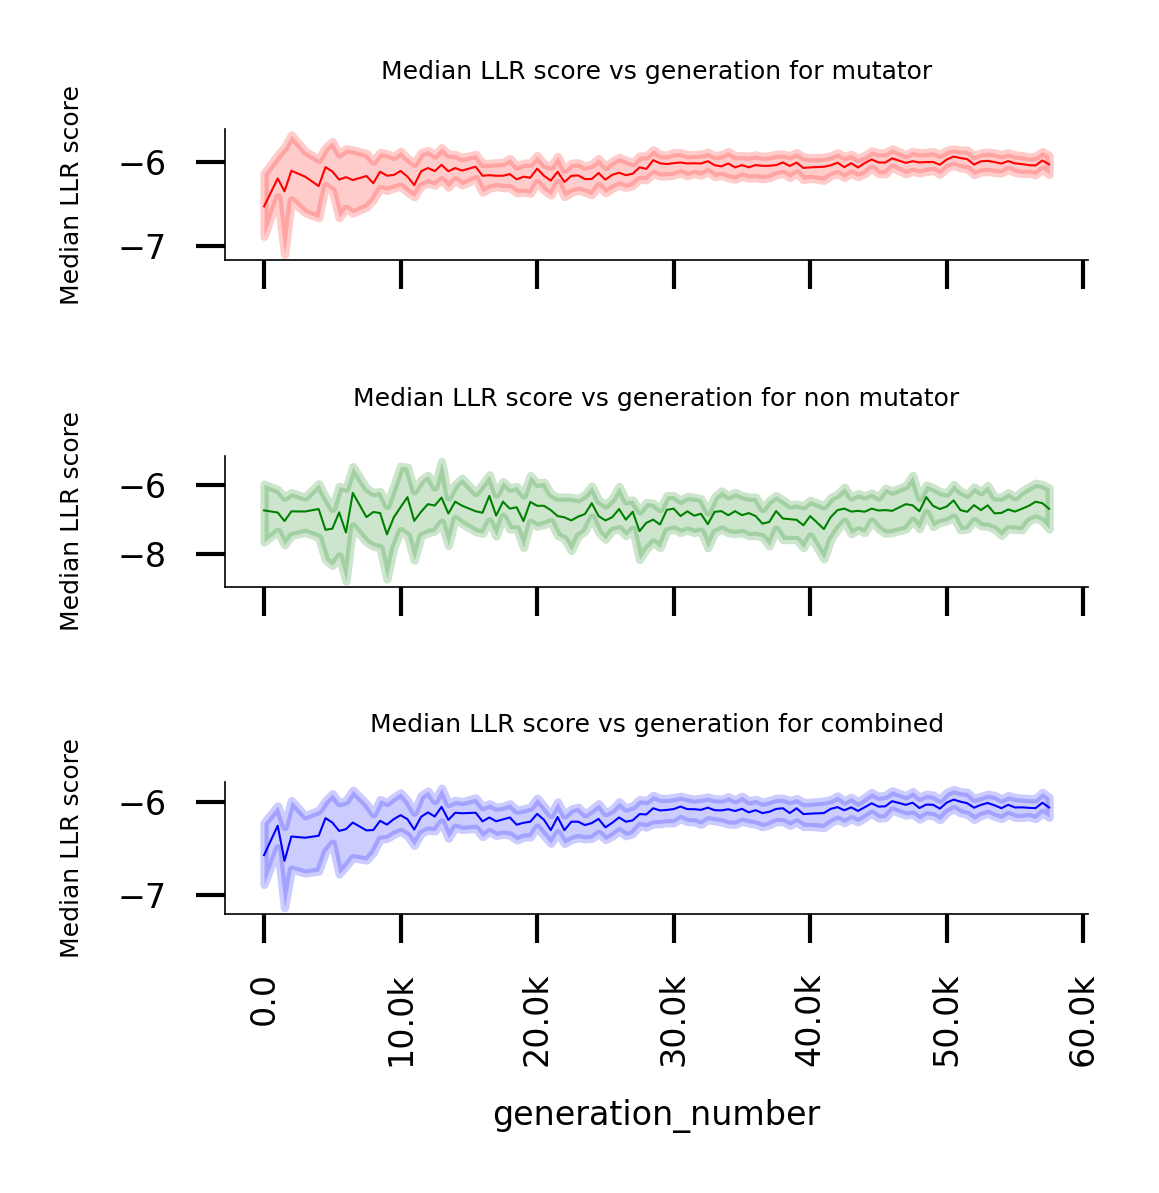

In [35]:
ax = utility.return_mutator_non_mutator_column_name_wise_graph_together(all_mutation_with_esm_1b_score_drop_na, mutator_list, non_mutator_list, column_name = "esm_score", fontsize = 3);
ax[0].set_title("Median LLR score vs generation for mutator", fontsize = 3)
ax[1].set_title("Median LLR score vs generation for non mutator", fontsize = 3)
ax[2].set_title("Median LLR score vs generation for combined", fontsize = 3)
ax[0].set_ylabel("Median LLR score", fontsize = 3)
ax[1].set_ylabel("Median LLR score", fontsize = 3)
ax[2].set_ylabel("Median LLR score", fontsize = 3)

##### calculate generation wise median of fitnesss and esm score for overall population, mutator, non mutator 

In [20]:
all_population_combined_esm_fitness_median = utility.return_combined_fitness_esm_data(df_Fitness2_experimental, all_mutation_with_esm_1b_score_drop_na)

mutator_population_combined_esm_fitness_median =  utility.return_combined_fitness_esm_data(fitness_dataframe = df_Fitness2_experimental[df_Fitness2_experimental.loc[:, "Mutator.Ever"]=="Yes"], 
esm_dataframe = all_mutation_with_esm_1b_score_drop_na[all_mutation_with_esm_1b_score_drop_na.loc[:, "mutator"]=="mutator"] )

non_mutator_population_combined_esm_fitness_median =   utility.return_combined_fitness_esm_data(fitness_dataframe = df_Fitness2_experimental[df_Fitness2_experimental.loc[:, "Mutator.Ever"]=="No"], 
esm_dataframe = all_mutation_with_esm_1b_score_drop_na[all_mutation_with_esm_1b_score_drop_na.loc[:, "mutator"]=="non mutator"] )

In [21]:
# all_population_combined_esm_fitness_median

##### Make a pairplot of esm vs fitness for overall population, mutator, non mutator 

/tmp/ipykernel_2149611/2798481591.py:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[0].figure.colorbar(sm)


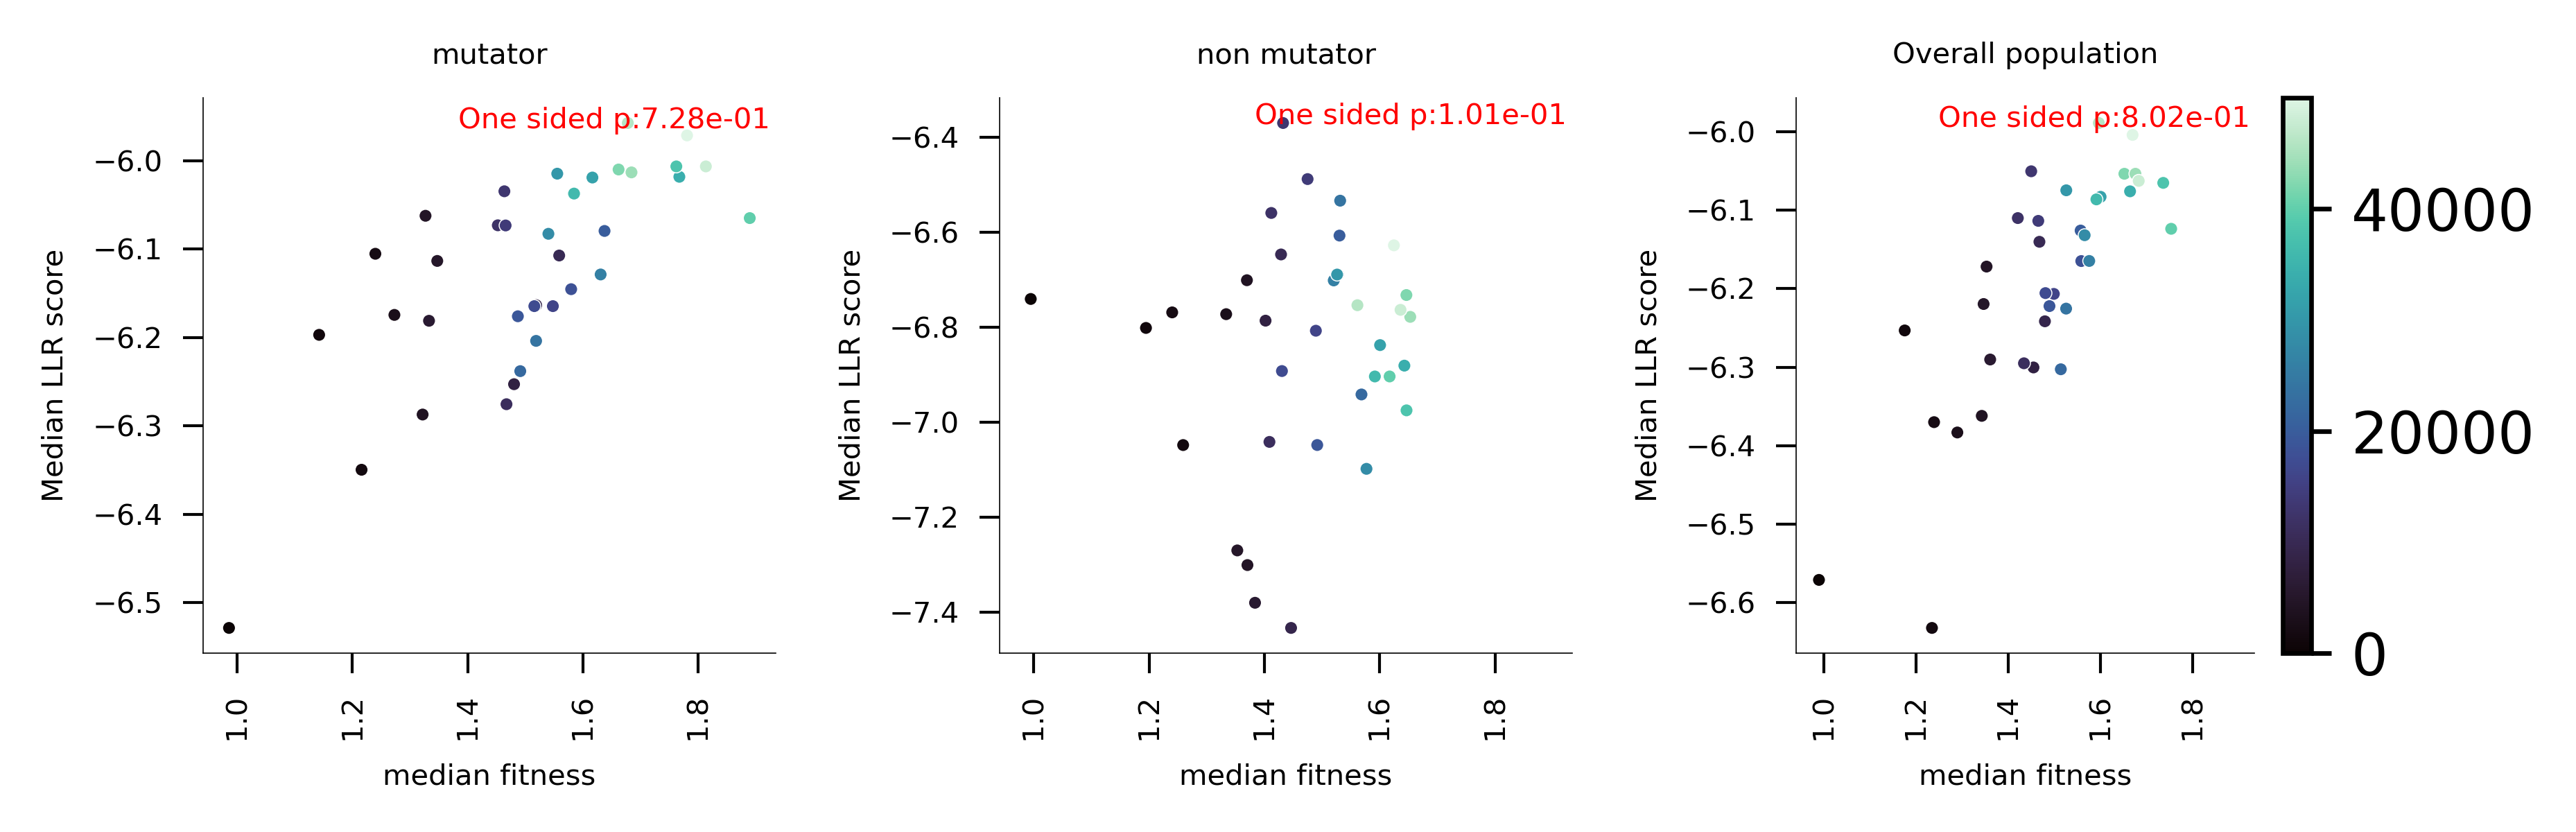

In [39]:
fig, ax = plt.subplots(1,  3, dpi = 600, figsize = (6.3, 2.1), sharex=True)
# sns.color_palette("mako", as_cmap=True)
norm = plt.Normalize(all_population_combined_esm_fitness_median['generation_number'].min(), all_population_combined_esm_fitness_median['generation_number'].max())
sm = plt.cm.ScalarMappable(cmap="mako", norm=norm)
# sm.set_array([])
ax[0] = sns.scatterplot(data= mutator_population_combined_esm_fitness_median, x = "median fitness", y = "median esm_score", hue="generation_number",ax= ax[0], legend=True, s = 5, palette='mako')


ax[1] = sns.scatterplot(data= non_mutator_population_combined_esm_fitness_median, x = "median fitness", y = "median esm_score", hue="generation_number",ax= ax[1], legend=False, s = 5, palette='mako')

ax[2] = sns.scatterplot(data= all_population_combined_esm_fitness_median, x = "median fitness", y = "median esm_score", hue="generation_number",ax= ax[2], legend=False, s = 5, palette='mako')

offset = 0.01

formatted_p_mutator = "{:.2e}".format(mutator_population_combined_esm_fitness_median["median fitness"].corr(mutator_population_combined_esm_fitness_median["median esm_score"]))
ax[0].text((max(ax[0].get_xlim()) - offset), (max(ax[0].get_ylim()) - offset), "One sided p:" + formatted_p_mutator, fontsize=5, color='red', ha='right', va='top')

formatted_p_non_mutator = "{:.2e}".format(non_mutator_population_combined_esm_fitness_median["median fitness"].corr(non_mutator_population_combined_esm_fitness_median["median esm_score"]))
ax[1].text((max(ax[1].get_xlim()) - offset), (max(ax[1].get_ylim()) - offset), "One sided p:" + formatted_p_non_mutator, fontsize=5, color='red', ha='right', va='top')

formatted_p_all = "{:.2e}".format(all_population_combined_esm_fitness_median["median fitness"].corr(all_population_combined_esm_fitness_median["median esm_score"]))
ax[2].text((max(ax[2].get_xlim()) - offset), (max(ax[2].get_ylim()) - offset), "One sided p:" + formatted_p_all, fontsize=5, color='red', ha='right', va='top')


ax[0].set_title("mutator", fontsize=5)
ax[1].set_title("non mutator", fontsize=5)
ax[2].set_title("Overall population", fontsize=5)



for i in range(3):
    ax[i] = utility.custom_figure_axis(ax[i], fontsize=5, show_ticks = True)
    ax[i].set_ylabel("Median LLR score")

ax[0].get_legend().remove()
ax[0].figure.colorbar(sm)

plt.tight_layout()

<!-- #### esm score vs generation upto 60K -->

##### Generation vs fitness for mutant and non mutant category

In [23]:
df_mutator = df_Fitness2_experimental[df_Fitness2_experimental.loc[:, "Mutator.Ever"]=="Yes"]
df_non_mutator = df_Fitness2_experimental[df_Fitness2_experimental.loc[:, "Mutator.Ever"]=="No"]
grouped_mutator_fitness = df_mutator.groupby('Generation')['Fitness'].agg(['median', 'std']).reset_index()
grouped_non_mutator_fitness = df_non_mutator.groupby('Generation')['Fitness'].agg(['median', 'std']).reset_index()
grouped_mutator_fitness.columns= ['Generation', "Median fitness", "Std of fitness"]
grouped_non_mutator_fitness.columns= ['Generation', "Median fitness", "Std of fitness"]

print("As per the trapezoidal rule, area under the mutator fitness curve across generation is : ", np.trapz(x = grouped_mutator_fitness["Generation"], y = grouped_mutator_fitness["Median fitness"]))
print("As per the trapezoidal rule, area under the non mutator fitness curve across generation is : ", np.trapz(x = grouped_non_mutator_fitness["Generation"], y = grouped_non_mutator_fitness["Median fitness"]))

As per the trapezoidal rule, area under the mutator fitness curve across generation is :  78356.80526875
As per the trapezoidal rule, area under the non mutator fitness curve across generation is :  75857.231003625


#### fitness vs generation graph

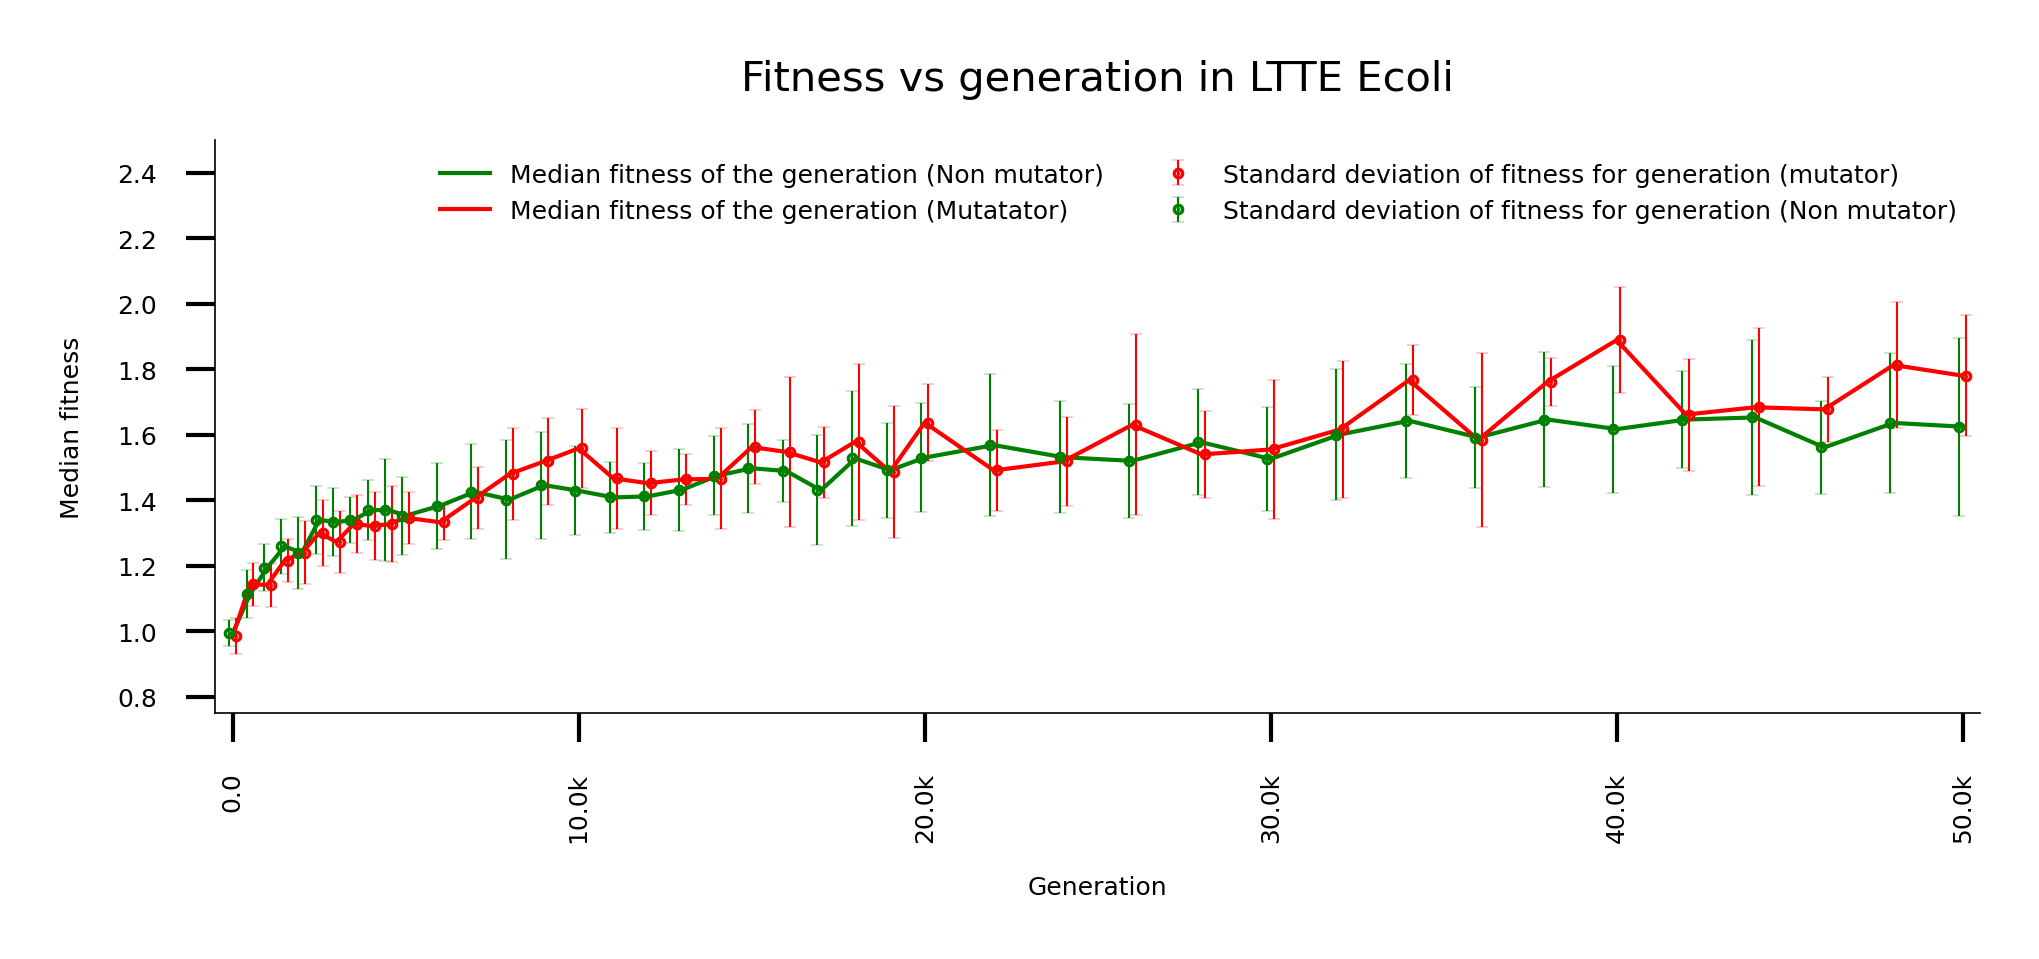

In [29]:
fig, ax = plt.subplots(1, 1 , dpi = 600, figsize = (3.5, 1.7))
from matplotlib.ticker import FuncFormatter

ax.errorbar(x = grouped_mutator_fitness["Generation"]+100, y = grouped_mutator_fitness["Median fitness"], yerr=grouped_mutator_fitness["Std of fitness"], fmt='o', capsize=0.75, label='Standard deviation of fitness for generation (mutator)', capthick=0.05, linewidth=0.25, color = "red", markersize=0.4)
ax.errorbar(x = grouped_non_mutator_fitness["Generation"]-100, y = grouped_non_mutator_fitness["Median fitness"], yerr=grouped_non_mutator_fitness["Std of fitness"], fmt='o', capsize=0.75, label='Standard deviation of fitness for generation (Non mutator)', capthick=0.05, linewidth=0.25, color ="green", markersize=0.4)
ax.plot(grouped_non_mutator_fitness["Generation"], grouped_non_mutator_fitness["Median fitness"], color = "green", label = "Median fitness of the generation (Non mutator)", lw = 0.5)
ax.plot(grouped_mutator_fitness["Generation"], grouped_mutator_fitness["Median fitness"], color ="red", label = "Median fitness of the generation (Mutatator)", lw = 0.5)
ax.legend(ncol=2, fontsize=3, frameon=False)
ax.set_ylim(0.75,2.5)
ax.set_xlim(-500,50500)
ax.set_ylabel("Median fitness")
ax.set_xlabel("Generation")
# Apply the custom tick formatter
formatter = FuncFormatter(utility.format_ticks)
ax.xaxis.set_major_formatter(formatter)
ax = utility.custom_figure_axis(ax, fontsize=3, show_ticks = True)

ax.set_title("Fitness vs generation in LTTE Ecoli", fontsize=5)
plt.tight_layout()
# plt.savefig("Generation vs fitness in ecoli custom.pdf", dpi = 600, bbox_inches="tight")

#### divide the data in two group <=30K and >30K

In [25]:
grouped_gen_30K = utility.return_generation_grouped_dataframe(all_mutation_with_esm_1b_score_drop_na, 30000, "<=30K", ">30K")
grouped_gen_30K.head()

,generation_number,mutator,esm_score,group_gen
0,0,mutator,-6.528539,<=30K
1,0,non mutator,-6.740957,<=30K
2,1000,mutator,-6.197031,<=30K
3,1000,non mutator,-6.801957,<=30K
4,1500,mutator,-6.349631,<=30K


##### box plot of esm score for mutator and non mutator while using 30K generation as cutoff group

Text(0.5, 1.0, 'Median LLR score vs mutant type')

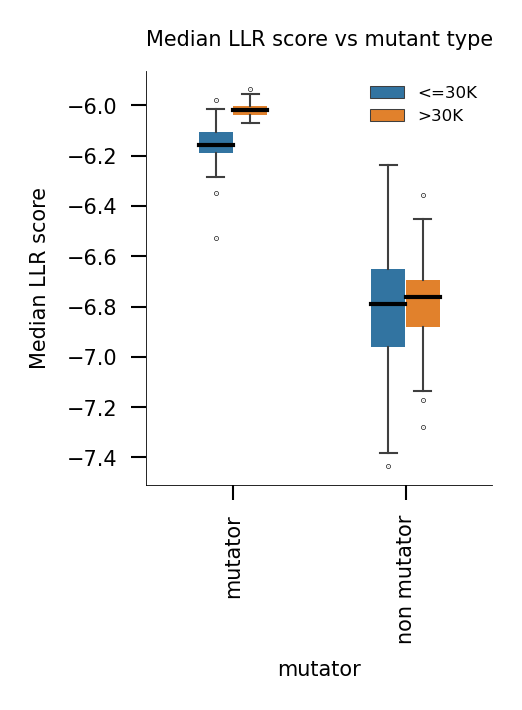

In [31]:
fig, ax = plt.subplots(1, 1 , dpi = 300, figsize = (2.1, 2.1), sharex=True)
sns.boxplot(data=grouped_gen_30K, x = "mutator", y = "esm_score", hue= "group_gen", dodge=20, ax = ax, boxprops=dict(edgecolor="black", linewidth=0),flierprops=dict(marker='o', markeredgecolor='black'), width=0.4,linewidth=0.5, fliersize=0.15, medianprops={"color": "black","linewidth":1})
ax.legend(fontsize=4, frameon=False)
plt.tight_layout()
ax = utility.custom_figure_axis(ax, fontsize=5, show_ticks = True)
ax.set_ylabel("Median LLR score")
ax.set_title("Median LLR score vs mutant type", fontsize = 5)

# plt.savefig("esm vs type in ecoli upto 60k gen.pdf", dpi = 600, bbox_inches="tight")

##### One sided mannwhitney test within the mutator groups for data points <=30K and >30K generation

In [27]:
mut_gen = grouped_gen_30K[grouped_gen_30K.loc[:, "mutator"]=="mutator"]
p_mut = utility.man_whiteney(mut_gen[mut_gen.loc[:, "group_gen"]==">30K"]["esm_score"], 
                                 mut_gen[mut_gen.loc[:, "group_gen"]=="<=30K"]["esm_score"])
print("The one sided man_whiteney p value within the mutator groups for data points <=30K and >30K generation is: ", str(p_mut))

The one sided man_whiteney p value within the mutator groups for data points <=30K and >30K generation is:  5.106678392961868e-16


##### One sided mannwhitney test within the non mutator groups for data points <=30K and >30K generation

In [28]:
non_mut_gen = grouped_gen_30K[grouped_gen_30K.loc[:, "mutator"]=="non mutator"]
p_non_mut = utility.man_whiteney(non_mut_gen[non_mut_gen.loc[:, "group_gen"]==">30K"]["esm_score"], 
                                 non_mut_gen[non_mut_gen.loc[:, "group_gen"]=="<=30K"]["esm_score"])
print("The one sided man_whiteney p value within the non mutator groups for data points <=30K and >30K is: ", str(p_non_mut))


The one sided man_whiteney p value within the non mutator groups for data points <=30K and >30K is:  0.19628716652263956
